In [1]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import textacy
import numpy as np
import pandas as pd 

# Define global variables

In [2]:
MAX_NUM = 1000
RAW_REVIEW_JSON = './data/yelp/review.json'
RAW_BUSINESS_JSON = './data/yelp/business.json'
nlp = spacy.load('en')

# Take a look at data format

In [3]:
f = open(RAW_BUSINESS_JSON)
f.readline()

'{"business_id": "FYWN1wneV18bWNgQjJ2GNg", "name": "Dental by Design", "neighborhood": "", "address": "4855 E Warner Rd, Ste B9", "city": "Ahwatukee", "state": "AZ", "postal_code": "85044", "latitude": 33.3306902, "longitude": -111.9785992, "stars": 4.0, "review_count": 22, "is_open": 1, "attributes": {"AcceptsInsurance": true, "ByAppointmentOnly": true, "BusinessAcceptsCreditCards": true}, "categories": ["Dentists", "General Dentistry", "Health & Medical", "Oral Surgeons", "Cosmetic Dentists", "Orthodontists"], "hours": {"Friday": "7:30-17:00", "Tuesday": "7:30-17:00", "Thursday": "7:30-17:00", "Wednesday": "7:30-17:00", "Monday": "7:30-17:00"}}\n'

In [4]:
f = open(RAW_REVIEW_JSON)
f.readline()

'{"review_id":"v0i_UHJMo_hPBq9bxWvW4w","user_id":"bv2nCi5Qv5vroFiqKGopiw","business_id":"0W4lkclzZThpx3V65bVgig","stars":5,"date":"2016-05-28","text":"Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \\n\\nThey ask you how you want you meat, lean or something maybe, I can\'t remember. Just say you don\'t want it too fatty. \\n\\nGet a half sour pickle and a hot pepper. Hand cut french fries too.","useful":0,"funny":0,"cool":0}\n'

# Define some helpful function

Filter out rules

In [5]:
# define rules to filter out unuseful tokens
def filter_token(token):
    if(token.is_punct or \
       token.is_digit or \
       token.is_space or \
       token.like_num or 
       token.is_stop) :
        return(False)
    else:
        return(True)

Read review `text` from json

In [6]:
# yield entire text for one review
def generate_review():
    reviews = textacy.io.read_json(RAW_REVIEW_JSON, mode='rt', lines=True)
    for review in reviews:
        yield review['text']

In [7]:
for text in generate_review():
    print(text)
    break

Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. 

They ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. 

Get a half sour pickle and a hot pepper. Hand cut french fries too.


# Phrase Model

## Prepare Sentence (tokens) List

- Process
    1. filter out based on rules
    2. lemmatize
    
    
- Output:  
**[**<br/>
[sentence 1 token 1, sentence 1 token 2], ..., [sentence 1 token K1],<br/>
[sentence 2 token 1, sentence 2 token 2], ..., [sentence 2 token K2],<br/>
...<br/>
[sentence N token 1, sentence N token 2], ..., [sentence N token KN]<br/>
**]**

In [8]:
def generate_list(max_num = MAX_NUM):
    all_reviews = generate_review()
    df = []
    
    for doc,_ in zip(nlp.pipe(all_reviews, batch_size=10, n_threads=3),  # parallel processing
                     range(max_num)):                                    # only MAX_NUM files
        for sent in doc.sents:
            df.append( [token.lemma_ for token in sent if filter_token(token) and token.lemma_ != '-PRON-'] )
    return(df)

In [9]:
unigram_sentences = generate_list()
len(unigram_sentences) # Number of sentences

13050

In [10]:
unigram_sentences[:5]

[['love', 'staff', 'love', 'meat', 'love', 'place'],
 ['prepare', 'long', 'line', 'lunch', 'dinner', 'hour'],
 ['ask', 'want', 'meat', 'lean', 'maybe', 'not', 'remember'],
 ['just', 'not', 'want', 'fatty'],
 ['get', 'half', 'sour', 'pickle', 'hot', 'pepper']]

## Train phrase model

In [11]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [12]:
bigram_model = Phraser(Phrases(unigram_sentences))
trigram_model = Phraser(Phrases(bigram_model[unigram_sentences]))

## Apply Phrase Model

- Process
    1. filter out based on rules
    2. lemmatize
    3. apply bigram and trigram phrase model


- Output:  
**[**<br/>
[Doc 1 token 1, Doc 1 token 2], ..., [Doc 1 token K1],<br/>
[Doc 2 token 1, Doc 2 token 2], ..., [Doc 2 token K2],<br/>
...<br/>
[Doc N token 1, Doc N token 2], ..., [Doc N token KN]<br/>
**]**

In [13]:
def apply_phrase_model(max_num = MAX_NUM):
    df = []
    for doc,_ in zip(nlp.pipe(generate_review(), batch_size=10, n_threads=3),
                   range(max_num)):
        unigram_review =  [token.lemma_ for token in doc if filter_token(token) and token.lemma_ != '-PRON-']
        bigram_review = bigram_model[unigram_review]
        trigram_review = trigram_model[bigram_review]
        df.append(trigram_review)
    return(df)

In [14]:
phrased_reviews = apply_phrase_model()
len(phrased_reviews)

1000

Take a look at bi- and tri- grams

In [15]:
' / '.join([word for phrased_review in phrased_reviews for word in phrased_review if '_' in word ][:15])

"long_line / lunch_dinner / not_remember / french_fry / pork_belly / smoke_meat / las_vegas / las_vegas / next_time / coffee_shop / gluten_free / gluten_free / valentine_'s_day / valentine_'s_day / valentine_'s_day"

# Topic Modelling - `gensim`

<img src="https://s3.amazonaws.com/skipgram-images/LDA.png" width= 400>

In [16]:
from gensim import corpora
from gensim.models import LdaMulticore
import pyLDAvis.gensim as gensimvis
import pyLDAvis

Create gensim `dictionary`

In [17]:
dictionary = corpora.Dictionary(phrased_reviews)
print(dictionary)

Dictionary(8425 unique tokens: ['ask', 'cut', 'fatty', 'french_fry', 'get']...)


An example of using dictionary (essentially just document-term matrix)

In [18]:
dictionary.doc2bow(phrased_reviews[300])

[(20, 1),
 (59, 1),
 (80, 1),
 (81, 1),
 (91, 2),
 (93, 1),
 (101, 2),
 (140, 1),
 (216, 1),
 (233, 1),
 (252, 1),
 (525, 1),
 (941, 1),
 (1144, 1),
 (1308, 1),
 (1385, 1),
 (1661, 1),
 (3349, 1),
 (3350, 1),
 (3351, 1),
 (3352, 1)]

Create gensim `corpus`

In [19]:
corpus = [dictionary.doc2bow(phrased_review) for phrased_review in phrased_reviews]
corpora.MmCorpus.serialize('./model/yelp_gensim_corpus.mm', corpus)  # store to disk, for later use
corpus = corpora.MmCorpus('./model/yelp_gensim_corpus.mm')

Train LDA model

In [20]:
lda = LdaMulticore(corpus, 
                   num_topics = 5, 
                   id2word = dictionary, 
                   workers = 3)

Take a look at top terms in first topic

In [21]:
lda.show_topic(0, topn=10)

[('the', 0.022097582),
 ('be', 0.017838163),
 ('not', 0.016510872),
 ('good', 0.014874373),
 ('place', 0.012055893),
 ('have', 0.008718221),
 ('time', 0.007516761),
 ('food', 0.00721077),
 ('like', 0.0059131137),
 ('come', 0.0058776326)]

Visualization

In [22]:
vis_data  = gensimvis.prepare(lda, corpus, dictionary)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [23]:
pyLDAvis.display(vis_data)

# Topic Modeling - `textacy`

Create Document-Term Matrix

In [24]:
vectorizer = textacy.vsm.Vectorizer(tf_type='linear', min_df = 1)
doc_term_matrix = vectorizer.fit_transform(phrased_reviews)
doc_term_matrix

<1000x8425 sparse matrix of type '<class 'numpy.int32'>'
	with 61521 stored elements in Compressed Sparse Row format>

Train Topic Model

In [25]:
model = textacy.tm.TopicModel('lda', n_topics=5) 
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

/Users/shiwang/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


(1000, 5)

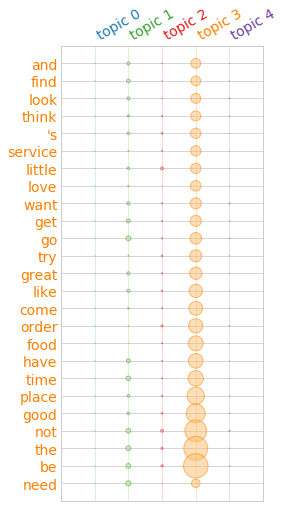

In [26]:
model.termite_plot(doc_term_matrix,  
                   vectorizer.id_to_term,
                   highlight_topics=[0,1,2,3,4])